In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import math
import warnings
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [38]:
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [39]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [40]:
categorical = df.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

mszoning
5
street
2
alley
2
lotshape
4
landcontour
4
utilities
2
lotconfig
5
landslope
3
neighborhood
25
condition1
9
condition2
8
bldgtype
5
housestyle
8
roofstyle
6
roofmatl
8
exterior1st
15
exterior2nd
16
masvnrtype
4
exterqual
4
extercond
5
foundation
6
bsmtqual
4
bsmtcond
4
bsmtexposure
4
bsmtfintype1
6
bsmtfintype2
6
heating
6
heatingqc
5
centralair
2
electrical
5
kitchenqual
4
functional
7
fireplacequ
5
garagetype
6
garagefinish
3
garagequal
5
garagecond
5
paveddrive
3
poolqc
3
fence
4
miscfeature
4
saletype
9
salecondition
6


In [41]:
#create lists of continuous and categorical variables
num_col = df.select_dtypes(['int64', 'float64']).columns
non_num = df.select_dtypes(['object']).columns

In [42]:
#for numeric variables, calculate the correlation to sales price for each
np.abs(df[num_col].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

In [43]:
#Use box cox transformation to shape sales price data into a more normal distribution
#Use this new variable in the regression model
df['adj_saleprice'],_ = boxcox(df['saleprice'])

In [44]:
#drop the 2 extreme outliers in general living area
df = df.drop(df[(df['grlivarea']>4000) & (df['saleprice']<300000)].index)

#transform the distribution for general living area
df['adj_livarea'],_ = boxcox(df['grlivarea'])

In [45]:
#add features to improve the pricing model

#create dummies for the zoning variable
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)

#create variable that includes total number of baths
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']

#variable that combines all the outdoor square footage
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']

#variable that gets the total square footage of each house
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

In [46]:
#create feature that looks at years built and remodelled for each house and judge new feature correlation
df['yrbuilt_yrremodel'] = df['yearbuilt'] * df['yearremodadd']

print('Corr. year built to salesprice = {:.3f}'.format(df['yearbuilt'].corr(df['saleprice'])))
print('Corr. year remoddled to salesprice = {:.3f}'.format(df['yearremodadd'].corr(df['saleprice'])))
print('Corr. feature of both years to salesprice = {:.3f}'.format(df['yrbuilt_yrremodel'].corr(df['saleprice'])))

Corr. year built to salesprice = 0.524
Corr. year remoddled to salesprice = 0.508
Corr. feature of both years to salesprice = 0.578


In [47]:
X = df.drop('saleprice', 1)
Y = np.log1p(df['adj_saleprice']) # Target variable
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [48]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1020
The number of observations in test set is 438


In [49]:
# Create Decision Tree classifer object
clf = DecisionTreeRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_preds = clf.predict(X_test)

In [50]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 0.00028253969604858406
Mean squared error of the prediction is: 2.7453553324367006e-07
Root mean squared error of the prediction is: 0.0005239613852600877
Mean absolute percentage error of the prediction is: 0.012968645005807331


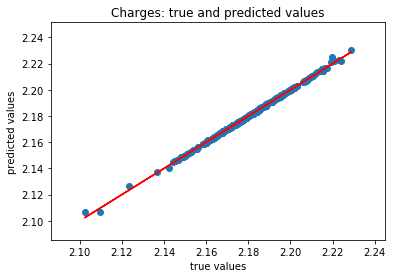

In [53]:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

In [54]:
X = df.drop('saleprice', 1)
Y = np.log1p(df['adj_saleprice']) # Target variable
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [56]:
import time
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

start_time = time.time()

rfc = ensemble.RandomForestRegressor()

cross_val_score(rfc, X_train,y_train, cv=10)

array([0.99981062, 0.99933407, 0.99814322, 0.99977594, 0.99749601,
       0.98958583, 0.99711362, 0.98967464, 0.99982   , 0.99817623])

In [57]:
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 7.61 seconds ---
